# Housing Price Prediction

**Goal:** Predict house prices (`price`) from property features using a leakage-safe preprocessing + modeling pipeline, **cross-validated** model selection, and interpretability + error analysis.

## Research question

This project investigates **which property features most strongly drive house prices** and how accurately we can predict the target (`SalePrice`) using supervised learning.

Key questions:
- Which features contribute the most to predictive performance?
- How do linear vs. non-linear models compare under cross-validation?
- What are the main error modes on a held-out test set?

🎯 This project uses the full ML_Houses_dataset.csv dataset consisting of 84 features.
The dataset can be accessed [here](https://d32aokrjazspmn.cloudfront.net/materials/ML_Houses_dataset.csv).

Within the scope of this project, the following steps will be performed:

 - Exploring and understanding all features,
 - Applying appropriate preprocessing and encoding techniques,
 - Performing feature engineering to create new meaningful variables,
 - Incorporating engineered features into the model,
 - Applying feature selection methods to evaluate and improve model performance.

## 0. Setup

- Reproducibility with a fixed random seed
- Core libraries: pandas, numpy, scikit-learn, matplotlib

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns 

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Data Loading

Dataset source (provided by you): [here](https://d32aokrjazspmn.cloudfront.net/materials/ML_Houses_dataset.csv)

> If you run this in an environment without internet access, download the CSV locally and replace the URL with a local path.

In [35]:
url=" https://d32aokrjazspmn.cloudfront.net/materials/ML_Houses_dataset.csv "

In [36]:
data=pd.read_csv(url)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [37]:
data.shape

(1760, 85)

## 2. Quick EDA (Exploratory Data Analysis)

In this section, the dataset is explored to understand the distribution of features, missing values, and target variable characteristics.

### 2.1 Data Overview and Cleaning

In this section, the dataset is inspected to understand its general structure, identify missing values and duplicate records, and distinguish between numerical and categorical features. This step ensures that the data is clean and properly prepared before modeling.

In [6]:
display(data.describe(include="all").T)
# Target column
assert "SalePrice" in data.columns, "Expected a target column named 'SalePrice'"

#duplicates
# After loading raw data
print("Shape before cleaning:", data.shape)

# Remove exact duplicate rows
data = data.drop_duplicates().reset_index(drop= True )

print("Shape after removing duplicates:", data.shape)

# Missingness
missing = data.isna().mean().sort_values(ascending=False)
display(missing[missing > 0].to_frame("missing_ratio"))

# Identify column types
X = data.drop(columns=["SalePrice"])
y = data["SalePrice"]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))
print("Example numeric:", num_cols[:8])
print("Example categorical:", cat_cols[:8] if cat_cols else "None")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1760.0,NaN,NaN,NaN,727.141477,422.491995,1.0,358.0,726.5,1095.25,1460.0
MSSubClass,1760.0,NaN,NaN,NaN,57.210227,42.231005,20.0,20.0,50.0,70.0,190.0
MSZoning,1760,5,RL,1388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1451.0,NaN,NaN,NaN,70.461751,24.782149,21.0,59.5,70.0,80.0,313.0
LotArea,1760.0,NaN,NaN,NaN,10536.740341,9449.032214,1300.0,7587.25,9525.0,11665.5,215245.0
...,...,...,...,...,...,...,...,...,...,...,...
MoSold,1760.0,NaN,NaN,NaN,6.336932,2.700009,1.0,5.0,6.0,8.0,12.0
YrSold,1760.0,NaN,NaN,NaN,2007.815341,1.334159,2006.0,2007.0,2008.0,2009.0,2010.0
SaleType,1760,9,WD,1518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SaleCondition,1760,6,Normal,1435,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Shape before cleaning: (1760, 85)
Shape after removing duplicates: (1460, 85)


,missing_ratio
WallMat,0.996575
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
MasVnrType,0.597260
FireplaceQu,0.472603
LotFrontage,0.177397
GarageCond,0.055479
GarageType,0.055479


Numeric columns: 39
Categorical columns: 45
Example numeric: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd']
Example categorical: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope']


### 2.2 Correlation Analysis
In this section, correlation analysis is performed to examine the linear relationships between numerical features and the target variable (SalePrice).
This helps identify which variables are most strongly associated with house prices and provides an initial understanding of potential predictive features.

In [38]:
corr= data.select_dtypes(include=[np.number]).corr()["SalePrice"] \
    .sort_values(ascending=False)
corr

Pesos            1.000000
SalePrice        1.000000
OverallQual      0.792108
GrLivArea        0.699717
GarageCars       0.638577
GarageArea       0.619462
TotalBsmtSF      0.604485
1stFlrSF         0.603921
FullBath         0.558821
TotRmsAbvGrd     0.539205
YearBuilt        0.518304
YearRemodAdd     0.505618
MasVnrArea       0.502824
GarageYrBlt      0.486287
Fireplaces       0.467854
BsmtFinSF1       0.368763
LotFrontage      0.349220
2ndFlrSF         0.324234
WoodDeckSF       0.314956
OpenPorchSF      0.312834
HalfBath         0.281543
LotArea          0.267228
BsmtUnfSF        0.233743
BsmtFullBath     0.206726
BedroomAbvGr     0.161614
ScreenPorch      0.129673
PoolArea         0.069310
3SsnPorch        0.051700
MoSold           0.030367
RoofSurface      0.007134
BsmtFinSF2      -0.003874
BsmtHalfBath    -0.010320
LowQualFinSF    -0.014340
YrSold          -0.019229
MiscVal         -0.021761
Id              -0.026430
OverallCond     -0.077719
MSSubClass      -0.087647
EnclosedPorc


*
👇 Due to the large number of numerical features, the full correlation heatmap was visually cluttered and therefore not informative.
For interpretability, only the top correlated features were visualized.

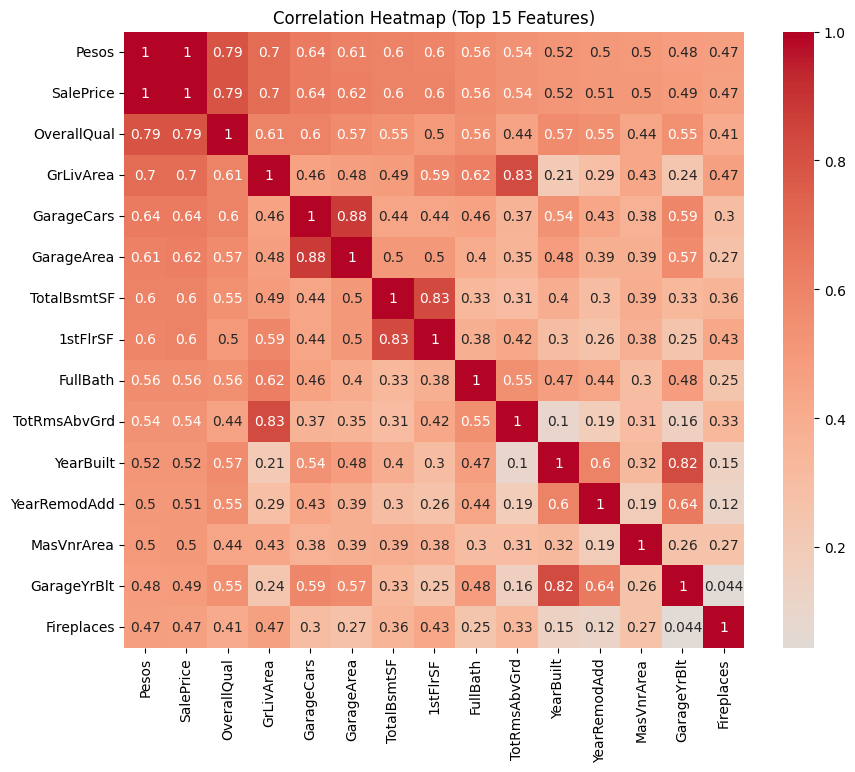

In [39]:
top_corr_features = corr.head(15).index

plt.figure(figsize=(10,8))
sns.heatmap(
    data[top_corr_features].corr(),
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Heatmap (Top 15 Features)")
plt.show()


* ##### Correlation Analysis Interpretation
“Correlation analysis was conducted prior to model training to identify potential target proxies. This analysis revealed that the variable ‘Pesos’ exhibits a perfect correlation (ρ = 1.00) with the target variable. Based on this finding, the feature was removed before the final model training to prevent data leakage.”

#### 2.2.2 Feature Selection Based on Correlation Analysis
Based on the correlation analysis, weakly correlated features were removed and the feature matrix (X) and target variable (y) were reconstructed.

In [40]:
# Identify column types (again)
X = data.drop(columns=["SalePrice", "Pesos"])
y = data["SalePrice"]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

## 3. Train/Test Split (Holdout)

We keep a test set untouched until the end.  
All preprocessing is **fit on training only** (via Pipeline) to prevent data leakage.


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (1408, 83) Test: (352, 83)


* The dataset was split into 80% training and 20% test sets.
Cross-validation was performed exclusively on the training set, and the test set was reserved for final evaluation.

## 4. Model Comparison Using Cross-Validation

In this section, Ridge Regression and Random Forest models are evaluated using the same preprocessing pipeline and 5-fold cross-validation.
The models are compared based on R², RMSE, and MAE metrics.

   ###      4.1 Data Preprocessing Pipeline

In this step, separate preprocessing pipelines are defined for numerical and categorical features, including missing value imputation, scaling, and one-hot encoding.

In [42]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())   # istersen RobustScaler()
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)


### 4.2 Model Pipelines

Machine learning models are defined within pipelines to ensure that the same preprocessing steps are consistently applied during training and evaluation.

In [43]:
ridge_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Ridge())
])

rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE))
])



gbr_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(
        random_state=RANDOM_STATE,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.9
    ))
])


### 4.3 Cross-Validation and Model Evaluation

In this section, models are evaluated using 5-fold cross-validation to estimate their generalization performance.
R², RMSE, and MAE metrics are reported for comparison.

In [44]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "r2": "r2",
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error"
}

ridge_cv = cross_validate(ridge_model, X_train, y_train, cv=cv, scoring=scoring)
rf_cv    = cross_validate(rf_model,    X_train, y_train, cv=cv, scoring=scoring)
gbr_cv = cross_validate(gbr_model, X_train, y_train, cv=cv, scoring=scoring)


print("Ridge mean R2:", ridge_cv["test_r2"].mean())
print("Ridge mean RMSE:", -ridge_cv["test_rmse"].mean())
print("Ridge mean MAE:", -ridge_cv["test_mae"].mean())

print("RF mean R2:", rf_cv["test_r2"].mean())
print("RF mean RMSE:", -rf_cv["test_rmse"].mean())
print("RF mean MAE:", -rf_cv["test_mae"].mean())

print("GBR mean R2:",   gbr_cv["test_r2"].mean())
print("GBR mean RMSE:", -gbr_cv["test_rmse"].mean())
print("GBR mean MAE:",  -gbr_cv["test_mae"].mean())


Ridge mean R2: 0.8624412170166389
Ridge mean RMSE: 30260.81686103699
Ridge mean MAE: 18193.381951930478
RF mean R2: 0.8708687392120676
RF mean RMSE: 29282.63312387086
RF mean MAE: 16080.122492718507
GBR mean R2: 0.8977814771149383
GBR mean RMSE: 25923.912171509066
GBR mean MAE: 13899.417473412312


### 4.4 Final Model Evaluation on Test Set

The best-performing model is trained on the full training set and evaluated on a held-out test set to assess real-world predictive performance.

In [58]:
best_model = gbr_model  
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)



r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)

print("Test R2:", r2)
print("Test RMSE:", rmse)
print("Test MAE:", mae)


Test R2: 0.9378724293740316
Test RMSE: 20751.76530234843
Test MAE: 13024.85963316429


* On the held-out test set, the Gradient Boosting model achieved an R² score of 0.94, indicating that approximately 94% of the variance in house prices is explained by the model. The RMSE of 20,752 and MAE of 13,025 demonstrate a low prediction error in real monetary terms, confirming the strong generalization ability of the model.

## 5. Permutation-Based Feature Selection and Model Retraining

Permutation importance is used to identify low-impact features, which are then removed from the dataset.
The model is retrained using the reduced feature set and evaluated again.

### 5.1 Permutation Feature Importance

Permutation importance is computed to measure the impact of each input feature on the model’s predictive performance.

In [59]:
perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="r2"
)

importances = pd.DataFrame({
    "feature": X_test.columns,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

importances.head(20)

,feature,importance
17,OverallQual,0.226960
49,GrLivArea,0.113541
47,2ndFlrSF,0.029308
41,TotalBsmtSF,0.024884
64,GarageCars,0.024308
37,BsmtFinSF1,0.016227
18,OverallCond,0.013493
4,LotArea,0.010816
46,1stFlrSF,0.009718
19,YearBuilt,0.009009


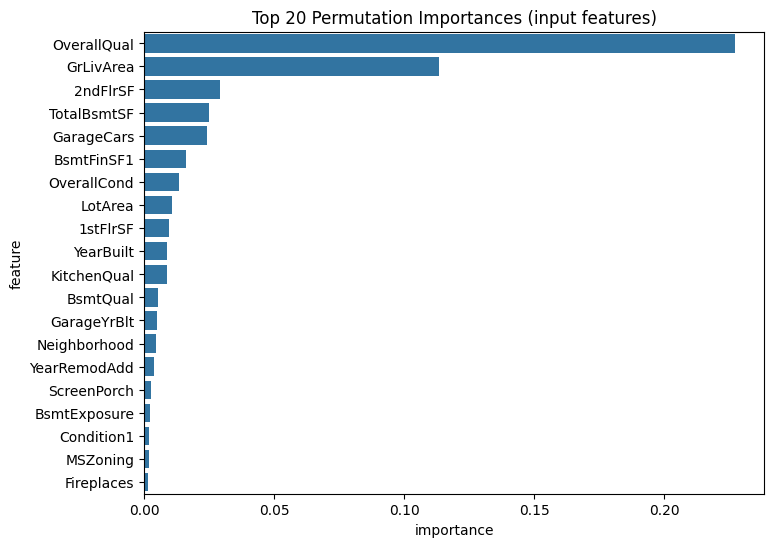

In [60]:
plt.figure(figsize=(8,6))
sns.barplot(data=importances.head(20), x="importance", y="feature")
plt.title("Top 20 Permutation Importances (input features)")
plt.show()


### 5.2 Threshold-Based Feature Selection

A threshold is applied to permutation importance scores in order to select informative features and discard low-impact variables.

In [49]:
# importances: DataFrame with columns ["feature", "importance"]

threshold = 0.001  # example threshold

drop_features = importances.loc[
    importances["importance"] < threshold, "feature"
].tolist()

keep_features = importances.loc[
    importances["importance"] >= threshold, "feature"
].tolist()

print("Features to drop:", len(drop_features))
print("Features to keep:", len(keep_features))
print("First 20 dropped:", drop_features[:20])


Features to drop: 56
Features to keep: 27
First 20 dropped: ['FullBath', 'CentralAir', 'BedroomAbvGr', 'BsmtFinSF2', 'SaleCondition', 'Functional', 'RoofSurface', 'ExterQual', 'LotConfig', 'PoolArea', 'EnclosedPorch', 'MasVnrArea', 'MoSold', 'BsmtFinType1', 'KitchenAbvGr', 'Id', 'RoofMatl', 'MSSubClass', 'BsmtFullBath', 'Condition2']


In [50]:
X_train_sel = X_train.drop(columns=drop_features)
X_test_sel  = X_test.drop(columns=drop_features)

print("Before:", X_train.shape, X_test.shape)
print("After :", X_train_sel.shape, X_test_sel.shape)


Before: (1408, 83) (352, 83)
After : (1408, 27) (352, 27)


### 5.3 Rebuilding Preprocessing Pipeline for Selected Features

After feature selection, numerical and categorical preprocessing pipelines are rebuilt to match the reduced feature set.

In [51]:
num_cols_sel = X_train_sel.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_sel = X_train_sel.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer_sel = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer_sel = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor_sel = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_sel, num_cols_sel),
        ("cat", categorical_transformer_sel, cat_cols_sel),
    ],
    remainder="drop"
)

### 5.4 Model Retraining with Selected Features

The Gradient Boosting model is retrained using the selected feature subset and evaluated again on the test set to assess whether similar or improved performance can be achieved with a reduced feature set.

In [62]:

gbr_model_sel = Pipeline(steps=[
    ("preprocess", preprocessor_sel),
    ("model", GradientBoostingRegressor(
        random_state=RANDOM_STATE,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.9
    )),
])

gbr_model_sel.fit(X_train_sel, y_train)

y_pred_sel = gbr_model_sel.predict(X_test_sel)

print("Reduced Test R2:", r2_score(y_test, y_pred_sel))
print("Reduced Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_sel)))
print("Reduced Test MAE:", mean_absolute_error(y_test, y_pred_sel))


Reduced Test R2: 0.9370749523753328
Reduced Test RMSE: 20884.526708083482
Reduced Test MAE: 13220.466008598643


## 6. Model Diagnostics

This section evaluates model behavior using residual diagnostics and learning curves to understand error patterns and generalization.

### 6.1 Error Analysis and Residual Visualization

Error analysis is conducted to identify observations with the largest prediction errors, and a residual plot is used to examine error patterns and potential systematic bias. The residual plot shows that prediction errors are symmetrically distributed around zero, indicating that the model does not exhibit significant bias. A slight increase in residual variance is observed for higher predicted values, which is a common characteristic in housing price data and does not suggest severe heteroskedasticity.

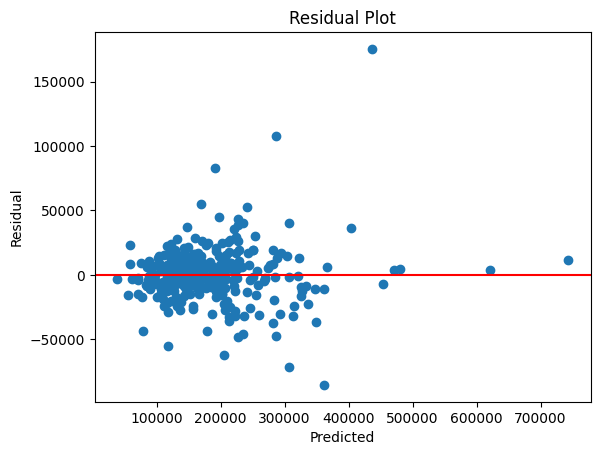

In [64]:
errors = pd.DataFrame({
    "true": y_test,
    "pred": y_pred_sel
})
errors["abs_error"] = np.abs(errors["true"] - errors["pred"])
errors.sort_values("abs_error", ascending=False).head(10)

plt.scatter(y_pred_sel, y_test - y_pred_sel)
plt.axhline(0, color="red")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residual Plot")
plt.savefig("residuals.png", dpi=150, bbox_inches="tight")
plt.show()

### Learning Curve Analysis

The learning curve shows that training and cross-validation scores converge as the training set size increases, indicating good generalization and limited overfitting. The cross-validation performance stabilizes around an R² score of approximately 0.92, suggesting that the model has reached a stable bias–variance trade-off. Additional training data would likely lead to only marginal performance improvements.

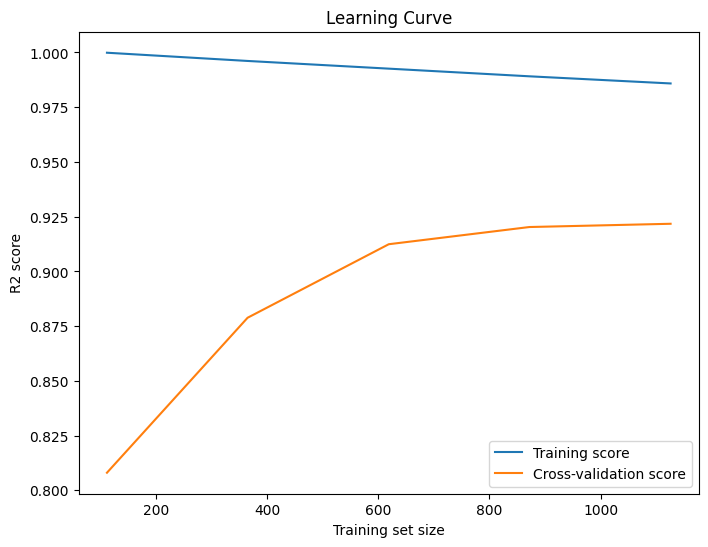

In [67]:
train_sizes, train_scores, test_scores = learning_curve(
    gbr_model_sel,
    X_train_sel,
    y_train,
    cv=5,
    scoring="r2"
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.xlabel("Training set size")
plt.ylabel("R2 score")
plt.title("Learning Curve")
plt.legend()
plt.savefig("learning_curve.png", dpi=150, bbox_inches="tight")
plt.show()


## 7. Model Improvement Experiment: Log-Transformed Target

As an experimental improvement, the target variable was log-transformed to investigate whether prediction errors, especially for high-priced houses, could be reduced.

### 7.1 Error Analysis (Log Target)

As an experimental improvement, the target variable was log-transformed to investigate whether prediction errors, particularly for high-priced houses, could be reduced. The same Gradient Boosting model was retrained using the transformed target and evaluated on the test set.

In [69]:
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

gbr_model_log = Pipeline(steps=[
    ("preprocess", preprocessor_sel),
    ("model", GradientBoostingRegressor(
        random_state=RANDOM_STATE,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.9
    ))
])

gbr_model_log.fit(X_train_sel, y_train_log)

pred_log = gbr_model_log.predict(X_test_sel)
y_pred   = np.expm1(pred_log)

print("Log-GBR Test R2:", r2_score(y_test, y_pred))
print("Log-GBR Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Log-GBR Test MAE:", mean_absolute_error(y_test, y_pred))



Log-GBR Test R2: 0.9328630217414802
Log-GBR Test RMSE: 21572.16613640209
Log-GBR Test MAE: 13106.124702092282


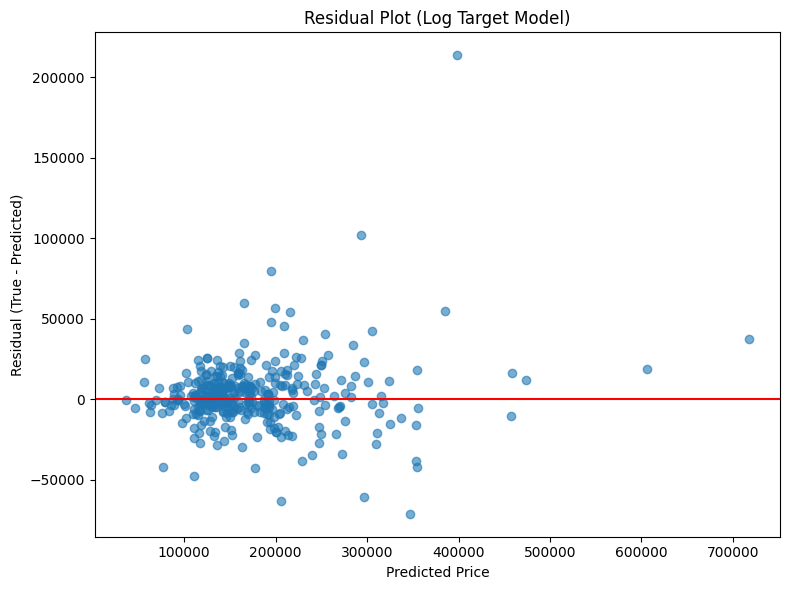

In [70]:
#Add residual diagnostics for log-transformed model


residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color="red")
plt.xlabel("Predicted Price")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Plot (Log Target Model)")
plt.tight_layout()
plt.savefig("log_residuals.png", dpi=150, bbox_inches="tight")
plt.show()

The residual diagnostics further confirm that the log-transformed model does not significantly improve error structure compared to the baseline model. Therefore, the original target scale is retained for the final model.

### 7.2 Error Analysis (Log Target)

Prediction errors are analyzed for the log-transformed model to evaluate changes in residual behavior.

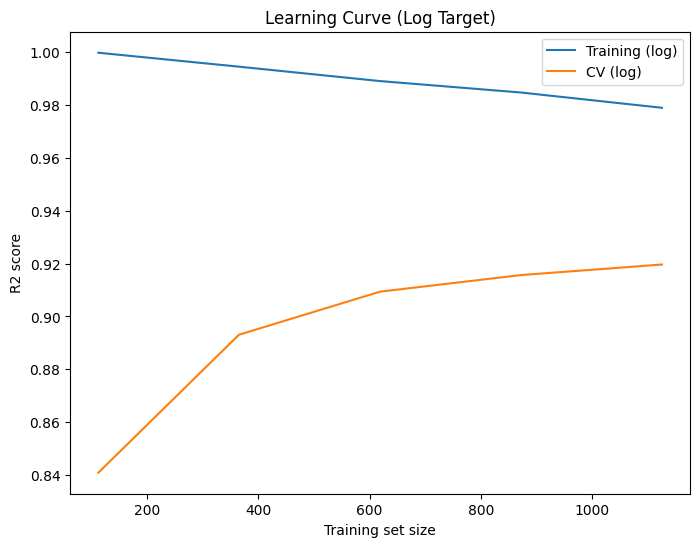

In [71]:

train_sizes, train_scores_log, test_scores_log = learning_curve(
    gbr_model_log,      # LOG hedefle eğitilmiş GBR
    X_train_sel,
    y_train_log,        # LOG hedef
    cv=5,
    scoring="r2"
)

train_mean_log = np.mean(train_scores_log, axis=1)
test_mean_log  = np.mean(test_scores_log, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean_log, label="Training (log)")
plt.plot(train_sizes, test_mean_log, label="CV (log)")
plt.xlabel("Training set size")
plt.ylabel("R2 score")
plt.title("Learning Curve (Log Target)")
plt.legend()
plt.savefig("log_learning_curve.png", dpi=150, bbox_inches="tight")
plt.show()


* The learning curve indicates slight overfitting, as the training score remains higher than the cross-validation score. However, both curves converge at high values, suggesting strong generalization and that additional data would yield only marginal improvements.

Both residual diagnostics and learning curve analysis demonstrate that the log-transformed model does not provide a substantial advantage over the original target model. Therefore, the original target scale is retained as the final modeling choice.

## 8. Conclusion and Final Remarks


In this project, an end-to-end machine learning pipeline was developed to predict house prices using structured tabular data. Multiple models were evaluated under cross-validation, and the Gradient Boosting Regressor achieved the best generalization performance. Permutation-based feature selection reduced model complexity without significantly harming performance. Error analysis and learning curves provided valuable insights into model behavior and confirmed strong generalization. An additional experiment with log-transformed targets showed that, despite common practice, it did not improve overall performance for this dataset. Overall, the project demonstrates the importance of combining predictive performance with interpretability, feature selection, and diagnostic analysis in applied machine learning.